## Import Packages, Define Variables

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from models.skip import skip
import torch
import torch.optim
from utils.utils import images_mean, similarity, load_image, show_img
from utils.common_utils import get_noise, torch_to_np, get_params, plot_image_grid

In [2]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
dtype = torch.cuda.FloatTensor

pad = "reflection"  #'zero'
OPT_OVER = "net"
OPTIMIZER = "adam"
PLOT = True
show_every = 10

# Create A Model

In [3]:
def get_model(
    input_shape=(256, 256), input_depth=2, input="meshgrid"
):
    net = skip(
        2,
        1,
        num_channels_down=[128] * 5,
        num_channels_up=[128] * 5,
        num_channels_skip=[64] * 5,
        upsample_mode="nearest",
        filter_skip_size=1,
        filter_size_up=3,
        filter_size_down=3,
        need_sigmoid=True,
        need_bias=True,
        pad=pad,
        act_fun="LeakyReLU",
    ).type(dtype)

    net = net.type(dtype)
    net_input = get_noise(input_depth, input, input_shape).type(
        dtype
    )
    s = sum(np.prod(list(p.size())) for p in net.parameters())
    print(f"model loaded, number of params: {s}")

    return net, net_input


## Inference Loop

In [4]:
def inference(
    degraded,
    lr=0.01,
    num_iter=200,
    param_noise=True,
    reg_noise_std=0.03,
):
    gt = np.moveaxis(torch_to_np(degraded), 0, -1)
    model, net_input = get_model()
    mse = torch.nn.MSELoss().type(dtype)
    candidates = []
    score_range = (97, 100)
    multiple = 0

    OVERFIT = 100
    RECONS = 0
    iter = 0
    # ----------------- History ----------------
    hist_recons = []
    hist_overfit = []
    hist_out = []
    # ----------------- History ----------------
    net_input_saved = net_input.detach().clone()
    noise = net_input.detach().clone()

    p = get_params(OPT_OVER, model, net_input)
    optimizer = torch.optim.Adam(p, lr=lr)

    while True:
        if iter == num_iter:
            break
        if RECONS == 100 and OVERFIT < 5:
            break
        optimizer.zero_grad()

        if param_noise:
            for n in [
                x for x in model.parameters() if len(x.size()) == 4
            ]:
                n = n + n.detach().clone().normal_() * n.std() / 50

        net_input = net_input_saved
        if reg_noise_std > 0:
            net_input = net_input_saved + (
                noise.normal_() * reg_noise_std
            )

        out = model(net_input)
        alpha = 0.2
        mask = degraded
        total_loss = alpha * mse(out * mask, degraded * mask) + (
            1 - alpha
        ) * mse((1 - out) * (1 - mask), (1 - degraded) * (1 - mask))
        image = np.moveaxis(torch_to_np(out), 0, -1)

        RECONS, OVERFIT = similarity(image, gt)

        # -------- History --------
        hist_recons.append(RECONS)
        hist_overfit.append(OVERFIT)
        hist_out.append(image)
        # -------------------------
        if (RECONS >= score_range[0]) and (
            RECONS <= score_range[1]
        ):
            candidates.append(image * OVERFIT)
            multiple += OVERFIT

        iter += 1

        if PLOT and iter % show_every == 0:
            out_np = torch_to_np(out)
            plot_image_grid(
                [np.clip(out_np, 0, 1)], factor=3, nrow=1
            )

        total_loss.backward()
        optimizer.step()

    if len(candidates) == 0:
        print("no candidactes found.")
        return np.zeros_like(image), (
            hist_out,
            hist_recons,
            hist_overfit,
        )
    recovered = images_mean(candidates, multiple)
    return recovered, (hist_out, hist_recons, hist_overfit)

# Load Images

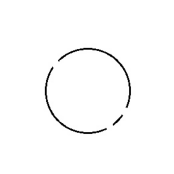

In [5]:
img_np, img_tensor = load_image('data/circle.jpg')
show_img(img_np, 2)

model loaded, number of params: 2560833


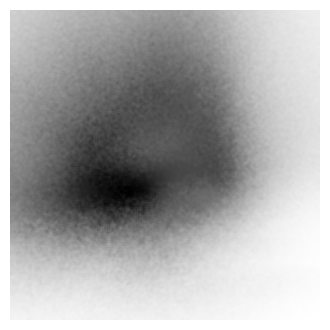

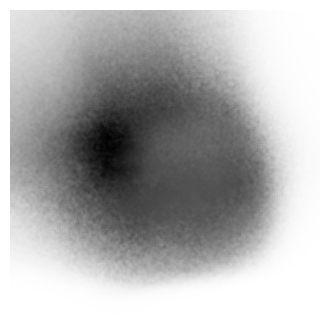

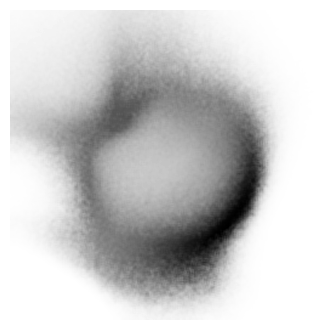

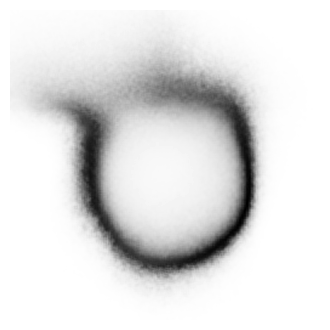

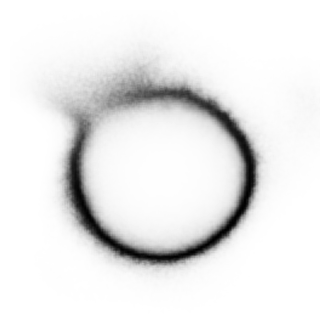

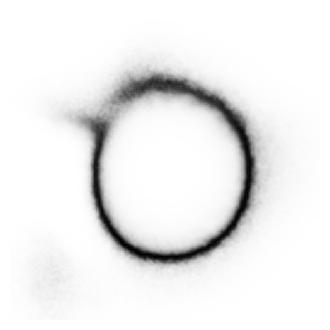

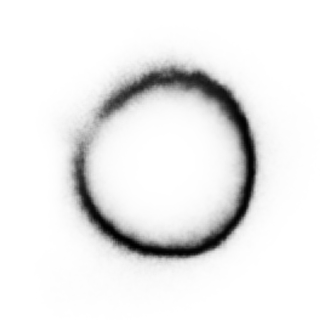

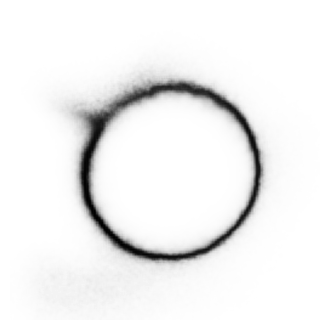

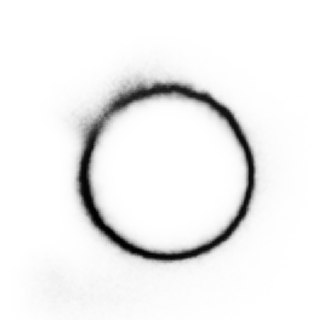

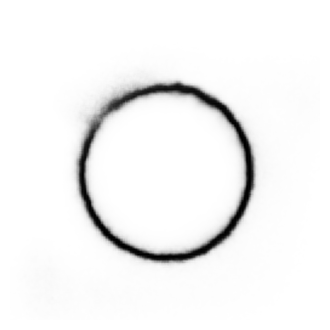

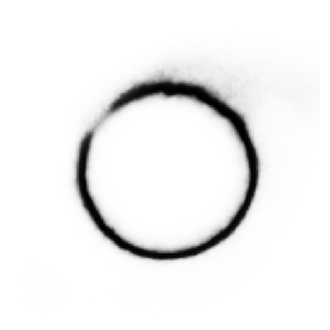

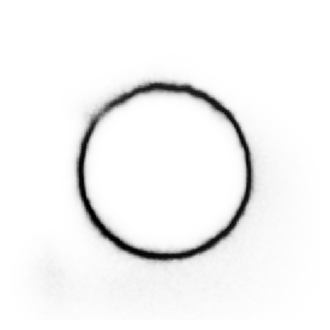

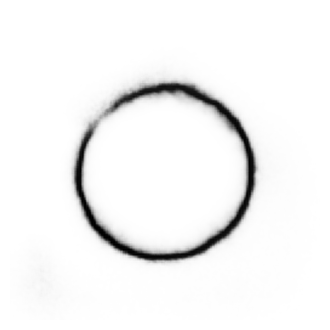

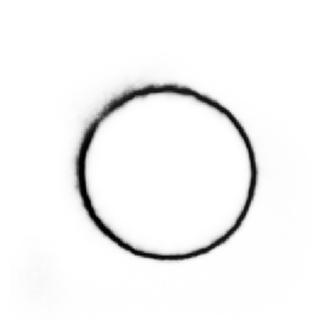

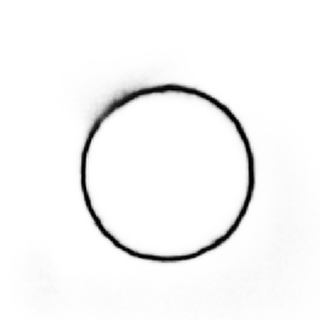

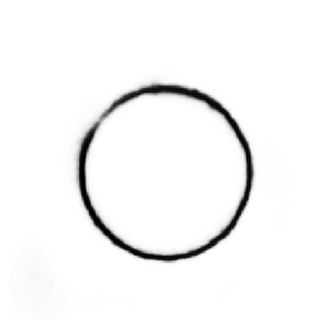

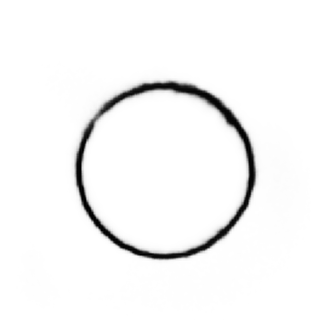

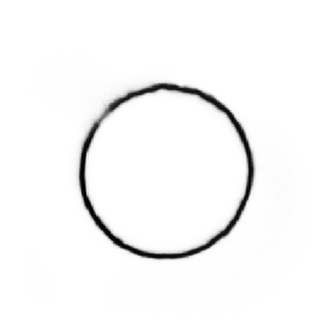

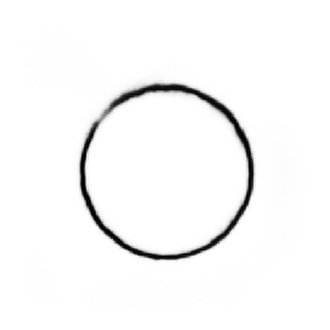

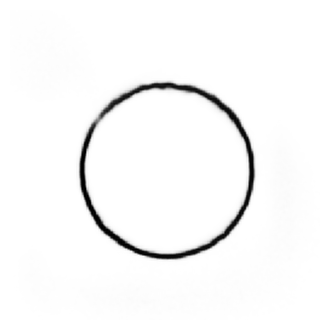

In [6]:
x_star, _ = inference(img_tensor)

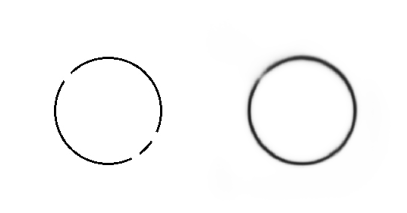

In [7]:
stacked = np.hstack((img_np[:,:,0], x_star[:,:,0]))
show_img(stacked)

In [8]:
PLOT = False

model loaded, number of params: 2560833


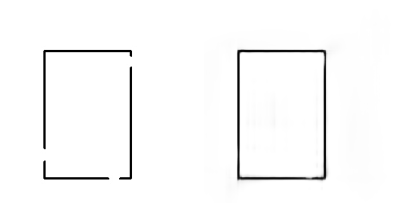

In [12]:
img_np, img_tensor = load_image('data/rect.jpg')
x_star, _ = inference(img_tensor)
stacked = np.hstack((img_np[:,:,0], x_star[:,:,0]))
show_img(stacked)

model loaded, number of params: 2560833


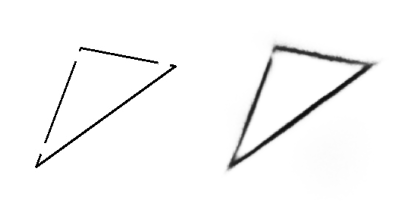

In [14]:
img_np, img_tensor = load_image('data/tri.jpg')
x_star, _ = inference(img_tensor)
stacked = np.hstack((img_np[:,:,0], x_star[:,:,0]))
show_img(stacked)